# Homework 3 - Larger Graphical Model

Brennan McFarland  
bfm21

## Problem Description

Suppose we want to monitor the success of a network packet transmission relative to various factors affecting the reliability of the network.  This information could be used to infer the condition of the network or troubleshoot problems based on such limited information as whether the packet was successfully transmitted and nothing else.

## Background

Our transmission utilizes an acknowledgement-based protocol such as TCP where the receiver can acknowledge back to the host which packets it has received.  This is a widespread technique to increase protocol reliability, as the sender can send a duplicate of the original packet if it has not received the corresponding acknowledgement within a given period of time.  Since our network will be affected by the error rate in a given transmission, we will also assume that this protocol is either not error-correcting or that repeated error-correction is liable to decrease the chances of successful packet transmission, for example by requiring more data to be sent that could potentially be lost.

## Probability Model

For our probability model we will take into account the following variables:

 - $V$ : successful packet transmission - binary (P is for probability and we use S and T elsewhere)
 - $D$ : number of duplicate packets sent thus far - discrete
 - $A$ : time since last packet acknowledgement - discrete (measured in time steps)
 - $E$ : packet error rate - discrete (measured in # errors)
 - $L$ : network load - discrete (measured in multiples of packets)
 - $U$ : network is up - binary
 - $S$ : sender is up - binary
 - $R$ : receiver is up - binary
 - $C$ : connection between sender and receiver is up - binary
 
Let the network then be defined by the following probabilities:



In [2]:
#TODO: once we have nice probs for the model, fill them in the above

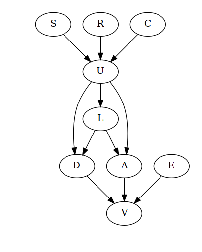

In [4]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('V', 'V')
dot.node('D', 'D')
dot.node('A', 'A')
dot.node('E', 'E')
dot.node('L', 'L')
dot.node('U', 'U')
dot.node('S', 'S')
dot.node('R', 'R')
dot.node('C', 'C')
dot.edges(['DV', 'AV', 'EV', 'LD', 'LA', 'UL', 'UD', 'UA', 'CU', 'RU', 'SU'])
path = 'exercise1-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg) # NOTE: the first time it might not show the image, if it doesn't just execute this block again

## Building the Model in Python

In [5]:
from pgmpy.models import BayesianModel as bysmodel
from pgmpy.factors.discrete import TabularCPD as tcpd
from pgmpy.factors.continuous import ContinuousFactor

In [6]:
# define model with connections between variables
model = bysmodel([('D', 'V'), ('A', 'V'), ('E', 'V'), ('L', 'D'), 
                  ('L', 'A'), ('U', 'D'), ('U', 'L'), ('U', 'A'),
                  ('S', 'U'), ('R', 'U'), ('C', 'U')])

In [7]:
# define discrete probability distributions
# TODO

In [77]:
import scipy
import math
import numpy as np
from typing import Tuple

disc_max = 5 # maximum value for discrete variables


# https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb

def binom(w, n, p):
    if(w < 0 or w > n):
       return 0
    # it stops trying to convert to float before calculating if the numbers are too large
    try:
        return float(math.factorial(n))/float(math.factorial(n-w)*math.factorial(w))*(p**w)*((1-p)**(n-w))
    except:
        return math.factorial(n)/(math.factorial(n-w)*math.factorial(w))*(p**w)*((1-p)**(n-w))

def pdf_binom(n, p):
    return [binom(i, n, p) for i in range(n)]

# return an array for a decreasing discrete distribution, falloff should be between 0 and 1 noninclusive
def decreasing_distribution(numvals):
    dist = [pdf_binom(numvals, .1)]
    dist_sum = np.sum(dist)
    # fix rounding error to it sums perfectly to 1
    if dist_sum < 1:
        pass
    elif dist_sum > 1:
        pass
    print(np.sum(dist))
    return dist

# define prior probabilities
# priorS = tcpd(variable='S', variable_card=2, values=[[0.90, 0.10]])
# priorR = tcpd(variable='R', variable_card=2, values=[[0.90, 0.10]])
# priorC = tcpd(variable='C', variable_card=2, values=[[0.80, 0.20]])
# priorE = tcpd(variable='E', variable_card=disc_max, values=decreasing_distribution(ranges['E']))

# TOODO: define reasonable probabilities, for dscrete/continuous?
# TODO: I think decreasing distribution should work now, but not sure

# define the range (ie number of possible values) of all variables
# the range of all binary variables is 2 values, true or false; we redundantly define them here for clarity
ranges = {'V': 2, 'S': 2, 'R': 2, 'C': 2, 'U': 2, 'D': 3, 'A': 10, 'E': 10, 'L': 50}

# prior probability
def ppd(prior):
    return tcpd(variable=prior, variable_card=ranges[prior], values=decreasing_distribution(ranges[prior]))

# conditional probability
def cpd(*variables):
    return tcpd(variable=variables[0], variable_card=ranges[variables[0]],
               evidence=variables[1:], evidence_card=[ranges[i] for i in variables[1:]],
               values=decreasing_distribution(np.prod([ranges[i] for i in variables])))

priorS = ppd('S')
priorR = ppd('R')
priorC = ppd('C')
priorE = ppd('E')
cpdV = cpd('V', 'D', 'A', 'E')
cpdA = cpd('A', 'L', 'U')
cpdD = cpd('D', 'L', 'U')
cpdL = cpd('L', 'U')
cpdU = cpd('U', 'S', 'R', 'C')
#cpdA = tcpd(variable='A', variable_card=2, 
#            evidence=['L', 'U'], evidence_card=[disc_max, 2], 
#            values=decreasing_distribution(disc_max, (disc_max**2)*2))
#cpdD = tcpd(variable='D', variable_card=2, 
#            evidence=['L', 'U'], evidence_card=[disc_max, 2], 
#            values=decreasing_distribution(disc_max, (disc_max**2)*2))
#cpdL = tcpd(variable='L', variable_card=disc_max, 
#            evidence=['U'], evidence_card=[2], 
#            values=decreasing_distribution(2, (disc_max**2)))
#cpdU = tcpd(variable='U', variable_card=2, 
#            evidence=['S', 'R', 'C'], evidence_card=[2], 
#            values=[[.9, .0, .0, .0, .0, .0, .0, .0], [.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

# add probabilities to the model
model.add_cpds(priorS, priorR, priorC, priorE, cpdV, cpdA, cpdD, cpdL, cpdU)
# check consistency
model.check_model()

0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9999999999000003
1.0000000000000167
1.0000000000000278
1.0000000000000084
1.0000000000000027
1.0000000000000002


ValueError: Sum of probabilites of states for node D is not equal to 1.

In [53]:
# add probabilities to the model
model.add_cpds(priorS, priorR, priorC, priorE, cpdV, cpdA, cpdD, cpdL, cpdU)
# check consistency
model.check_model()

NameError: name 'cpdV' is not defined